In [1]:
import numpy as np
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray, rgba2rgb
from skimage.util import img_as_float32, img_as_ubyte
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import binary_opening, binary_closing
from skimage.transform import rescale, rotate
from skimage.segmentation import flood_fill

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AttributeError: ignored

In [7]:
MS073_path = "./DistCount/test/Manuscripts/MS073"
Einsiedeln_path = "./DistCount/test/Manuscripts/Einsiedeln"
Halifax_path = "./DistCount/test/Manuscripts/Halifax"
Einsie_path = "./DistCount/test/Manuscripts/Test_Data/Einsie.jpg"
Hali_path = "./DistCount/test/Manuscripts/Test_Data/Hali.png"
MS_path = "./DistCount/test/Manuscripts/Test_Data/MS.jpg"

# New Section

In [8]:
# Functions
def get_images(path, stop_after):
    image_dict = {}
    for idx, filename in enumerate(os.listdir(path)):
        if idx == stop_after: # comment these two lines to obtain a certain number of images
            break
        image = cv2.cvtColor(cv2.imread(path + '/' + filename), cv2.COLOR_RGB2BGR)
        image_dict[filename] = image
        print(filename)
    return image_dict

def get_image(path):
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_RGB2BGR)
    return image

def fill_corners(input_image, fill_value=0, thresh=1, tol=None, fill_below_thresh=True):

    s = input_image.shape

    if (input_image[0,0] < thresh) == fill_below_thresh:
        input_image = flood_fill(input_image, (0, 0), fill_value, tolerance=tol)
    if (input_image[-1, 0] < thresh) == fill_below_thresh:
        input_image = flood_fill(input_image, (s[0] - 1, 0), fill_value, tolerance=tol)
    if (input_image[0, -1] < thresh) == fill_below_thresh:
        input_image = flood_fill(input_image, (0, s[1] - 1), fill_value, tolerance=tol)

    # This statement would cause the job to hang, but a statement like this could be used for the bottom right corner.
    # if input_image[-1, -1] < thresh:
    #     input_image = flood_fill(input_image, (-1, -1), 1, tolerance=tol)

    return input_image

def find_rotation_angle(img, coarse_bound=4, fine_bound=0.1, rescale_amt=0.5):
    num_trials = int(coarse_bound / fine_bound)
    img_resized = rescale(img, rescale_amt, order=0, multichannel=False)

    def project_angles(img_to_project, angles_to_try):
        best_angle = 0
        highest_variation = 0
        for a in angles_to_try:
            rot_img = rotate(img_to_project, a, mode='edge')
            proj = np.sum(rot_img, 1).astype('int64')
            variation = np.sum(np.diff(proj) ** 2)
            if variation > highest_variation:
                highest_variation = variation
                best_angle = a
        return best_angle

    angles_to_try = np.linspace(-coarse_bound, coarse_bound, num_trials)
    coarse_angle = project_angles(img_resized, angles_to_try)

    angles_to_try = np.linspace(-fine_bound + coarse_angle, fine_bound + coarse_angle, num_trials)
    fine_angle = project_angles(img_resized, angles_to_try)

    return fine_angle

def preprocess_images(input_image, soften=5, fill_holes=5):
    # ensure that all points which are transparent have RGB values of 255 (will become white when
    # converted to non-transparent grayscale.)
    input_image = img_as_float32(input_image)
    if len(input_image.shape) == 3 and input_image.shape[2] == 4:
        input_image = rgba2rgb(input_image)
    gray_img = img_as_ubyte(rgb2gray(input_image))

    # get the otsu threshold after running a flood fill on the corners, so that those huge clumps of
    # dark pixels don't mess up the statistics too much (we only care about text!)
    thresh = threshold_otsu(fill_corners(gray_img, fill_value=255, thresh=5, tol=1, fill_below_thresh=True))

    # n.b. here we are setting black pixels from the original image to have a value of 1 (effectively inverting
    # what you would get from a normal binarization, because the math gets easier this way)
    img_bin = img_as_ubyte(gray_img < thresh)
    img_blur_bin = img_as_ubyte(img_as_ubyte(gaussian(gray_img, soften)) < thresh)

    # now, fill corners of binarized images with black (value 0)
    img_bin = fill_corners(img_bin, fill_value=0, thresh=1, tol=1, fill_below_thresh=False)
    img_blur_bin = fill_corners(img_blur_bin, fill_value=0, thresh=1, tol=1, fill_below_thresh=False)

    # run smoothing on the blurred-binarized image so we get blobs of text in neat lines
    kernel = np.ones((fill_holes, fill_holes), np.uint8)
    img_cleaned = binary_opening(binary_closing(img_blur_bin, kernel), kernel)

    # find rotation angle of cleaned, smoothed image. use that to correct the rotation of the unsmoothed image
    angle = find_rotation_angle(img_cleaned)
    img_cleaned_rot = rotate(img_cleaned, angle, order=0, mode='edge') > 0
    img_bin_rot = rotate(img_bin, angle, order=0, mode='edge') > 0

    return img_bin_rot, img_cleaned_rot, angle

def plot_image(image, title, cmap=None):
    plt.figure(figsize=(6, 6))  # You can adjust the size as needed
    plt.imshow(image, cmap=cmap)
    plt.title(title)  # Optional title
    plt.axis('off')  # To hide axis values
    plt.show()

def plot_histogram(histogram):
    plt.figure(figsize=(20, 10))
    plt.plot(range(len(histogram)), histogram)
    plt.xlabel('Row')
    plt.ylabel('Count of 1s')
    plt.title('Count of 1s in each row')
    plt.show()

In [9]:
# Attributes
MS073_names_images = get_images(MS073_path, 10)
Einsiedeln_names_images = get_images(Einsiedeln_path, 10)
Halifax_names_images = get_images(Halifax_path, 10)

FileNotFoundError: ignored

In [ ]:
MS = get_image(MS_path)
Einsie = get_image(Einsie_path)
Hali = get_image(Hali_path)

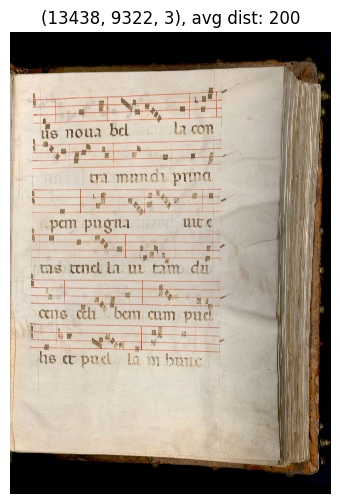

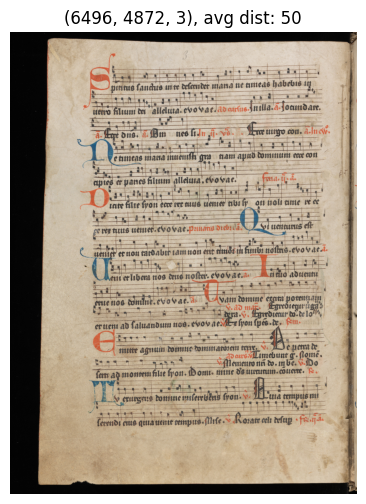

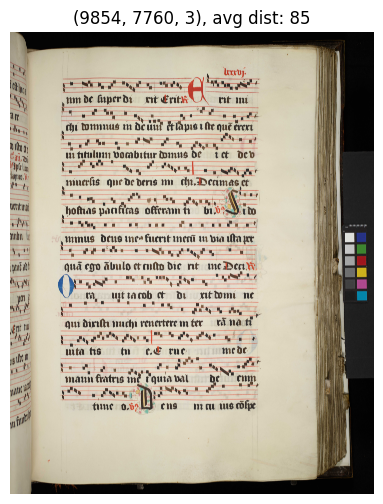

In [ ]:
plot_image(MS, str(MS.shape)+", avg dist: 200")
plot_image(Einsie, str(Einsie.shape)+", avg dist: 50")
plot_image(Hali, str(Hali.shape)+", avg dist: 85")

In [ ]:
ms_img = MS073_names_images["_A_15th_century_Italian_antiphonal___manuscript__0_115_p.__0.jpg"]
ein_img = Einsiedeln_names_images["Einsiedeln__Stiftsbibliothek__Codex_611_024r.jpg"]
hal_img = Halifax_names_images["Halifax_-_Saint_Mary_s_University_-_Patrick_Power_Library_-_ms._M2149.L4_I_108r.png"]

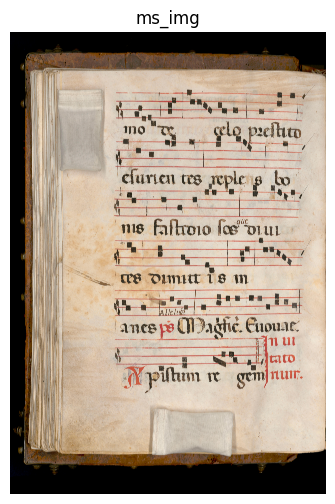

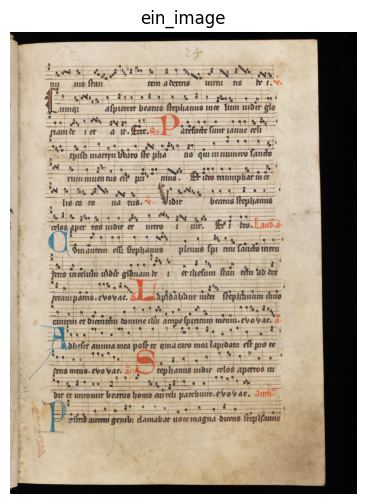

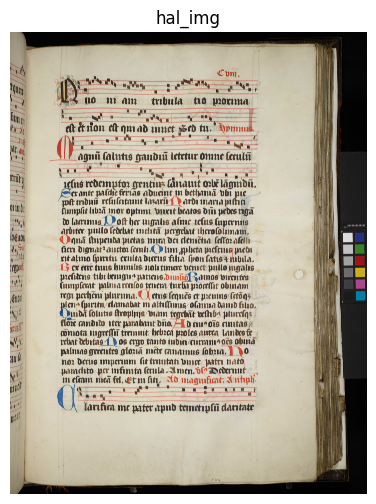

In [ ]:
plot_image(ms_img, "ms_img")
plot_image(ein_img, "ein_image")
plot_image(hal_img, "hal_img")

In [ ]:
ms_bin_rot, ms_cleaned_rot, ms_angle = preprocess_images(ms_img)

In [ ]:
ein_bin_rot, ein_cleaned_rot, ein_angle = preprocess_images(ein_img)

<ipython-input-4-1dce2df997d3>:31: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img_resized = rescale(img, rescale_amt, order=0, multichannel=False)


In [ ]:
hal_bin_rot, hal_cleaned_rot, hal_angle = preprocess_images(hal_img)

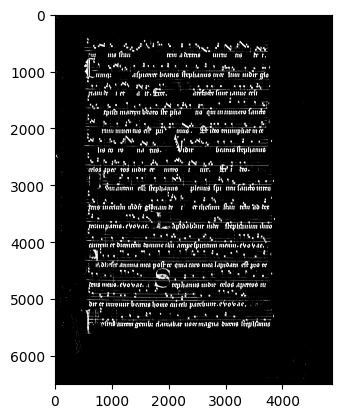

In [ ]:
plt.imshow(ein_bin_rot, cmap='gray')

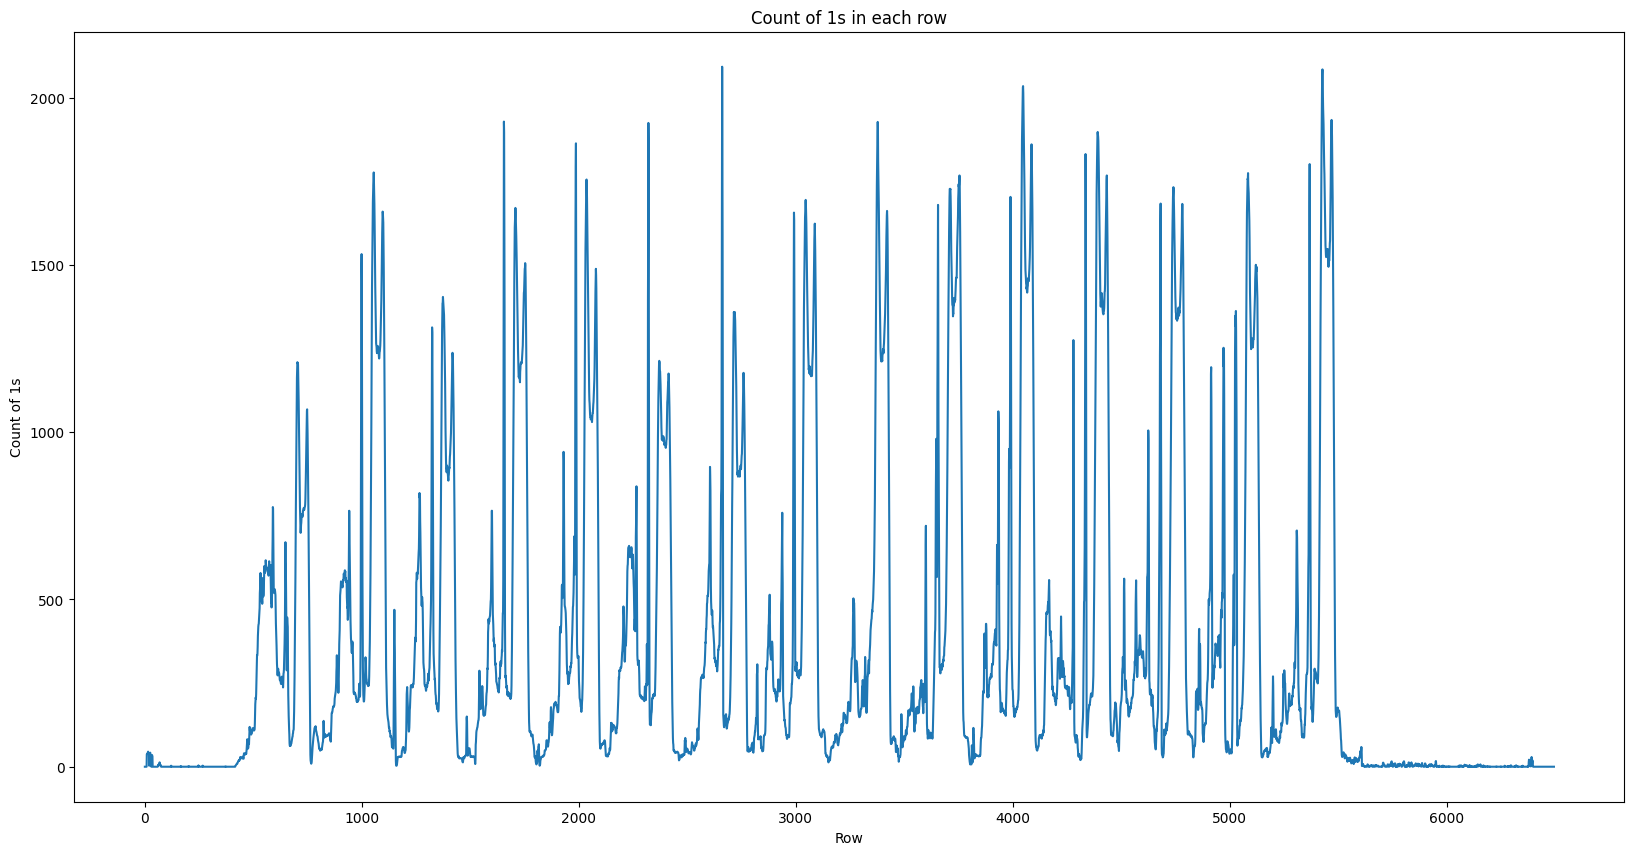

In [ ]:
ein_histogram = np.sum(ein_bin_rot, axis=1)
plot_histogram(ein_histogram)

In [ ]:
from scipy.signal import find_peaks

ein_threshold = np.mean(ein_histogram) + 2 * np.std(ein_histogram)
filtered_ein_histogram = np.where(ein_histogram < ein_threshold, 0, ein_threshold)
ein_peak_indices = np.where(filtered_ein_histogram != 0)[0]
ein_distances = np.diff(ein_peak_indices)
print(np.mean(ein_distances))

8.177007299270073


1305.6747212964708


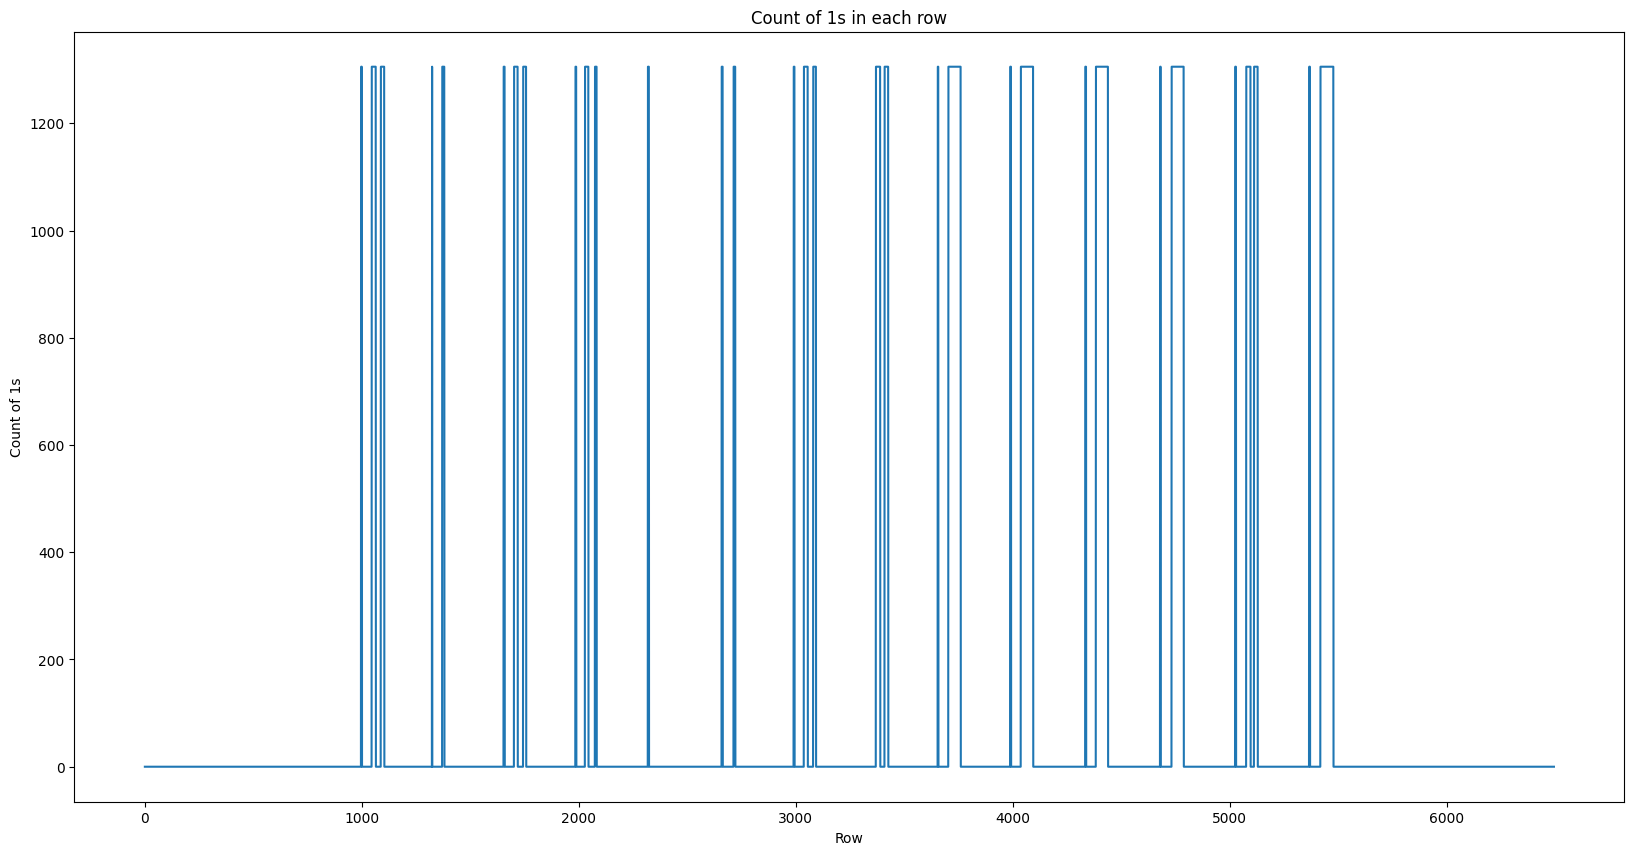

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(ein_threshold)
plot_histogram(filtered_ein_histogram)
print(filtered_ein_histogram)

In [ ]:
print(ein_peak_indices)

[ 997  998  999 1000 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1088 1089 1090 1091 1092
 1093 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1324 1371 1372
 1373 1374 1375 1376 1377 1378 1379 1380 1654 1655 1656 1657 1658 1702
 1703 1704 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716
 1717 1718 1744 1745 1746 1747 1748 1749 1750 1751 1752 1753 1754 1755
 1756 1757 1985 1986 1987 1988 2029 2030 2031 2032 2033 2034 2035 2036
 2037 2038 2039 2040 2041 2042 2043 2044 2075 2076 2077 2078 2079 2080
 2081 2082 2319 2320 2321 2322 2323 2659 2660 2661 2662 2663 2714 2715
 2716 2717 2718 2719 2720 2721 2991 2992 2993 2994 3038 3039 3040 3041
 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3081 3082 3083 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3370
 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381 3382 3383 3384
 3385 3386 3387 3388 3389 3410 3411 3412 3413 3414 3415 3416 3417 3418
 3419 